<a href="https://colab.research.google.com/github/ramsundar619/New-York-City-Taxi-Fare-Prediction/blob/main/NA19B065_Sundaresan_R_prediction_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import lightgbm as lgbm

In [ ]:
train_df =  pd.read_csv('/content/train_data_iitm.csv') # reading train_data
train_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge
0,2.0,2020-06-10 13:36:49,2020-06-10 13:51:08,1.0,2.73,1.0,N,224,148,2.0,12.00,2.5
1,NaN,2020-06-13 06:19:00,2020-06-13 06:37:00,NaN,11.58,NaN,NaN,56,42,NaN,28.81,0.0
2,2.0,2020-06-20 07:59:23,2020-06-20 08:05:39,1.0,2.05,1.0,N,79,68,2.0,8.00,2.5
3,1.0,2020-06-27 15:11:32,2020-06-27 15:15:02,1.0,1.40,1.0,N,236,75,1.0,6.00,2.5
4,1.0,2020-06-26 16:00:36,2020-06-26 16:02:28,1.0,0.60,1.0,N,186,90,2.0,4.00,2.5


In [ ]:
train_df.isnull().sum().sort_index() # checking for null values

DOLocationID                0
PULocationID                0
RatecodeID               5635
VendorID                 5635
congestion_surcharge        0
fare_amount                 0
passenger_count          5635
payment_type             5635
store_and_fwd_flag       5635
tpep_dropoff_datetime       0
tpep_pickup_datetime        0
trip_distance               0
dtype: int64

In [ ]:
train_df = train_df.dropna(how = 'any', axis = 'rows') # dropping null values
train_df = train_df.drop(columns = ['store_and_fwd_flag']) # store_and_fwd_flag feature values be only 'N' after remvoing NAN values which will not contribute to prediction

In [ ]:
train_df.describe() # statistical analysis of features

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge
count,54365.000000,54365.000000,54365.000000,54365.000000,54365.000000,54365.000000,54365.000000,54365.000000,54365.000000
mean,1.597554,1.353702,2.830018,1.047383,160.418633,155.555836,1.373604,11.840025,2.102594
std,0.490395,1.012809,3.573520,1.078021,68.550260,73.584395,0.532802,11.302908,0.942838
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-149.000000,-2.500000
25%,1.000000,1.000000,1.000000,1.000000,107.000000,90.000000,1.000000,6.000000,2.500000
50%,2.000000,1.000000,1.700000,1.000000,161.000000,158.000000,1.000000,8.500000,2.500000
75%,2.000000,1.000000,3.140000,1.000000,234.000000,234.000000,2.000000,13.500000,2.500000
max,2.000000,6.000000,114.300000,99.000000,265.000000,265.000000,5.000000,400.000000,2.500000


Text(0, 0.5, 'Frequency')

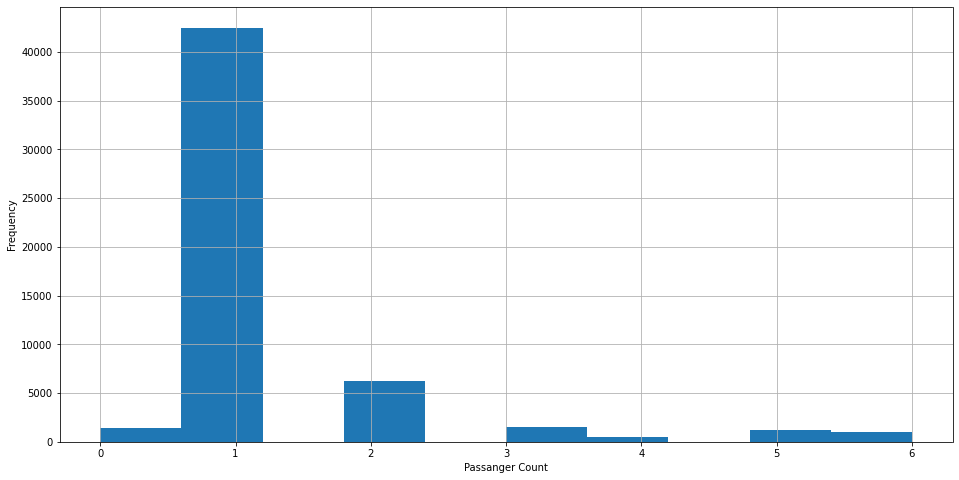

In [ ]:
train_df[train_df.passenger_count < 7].passenger_count.hist(bins=10, figsize = (16,8)) # analysis of passenger_count
plt.xlabel("Passanger Count")
plt.ylabel("Frequency")

In [ ]:
train_df.drop(train_df[train_df['passenger_count'] == 0].index, axis=0, inplace = True) # number of passengers cannot be 0

In [ ]:
train_df[train_df.passenger_count <7][['fare_amount','passenger_count']].corr() # shows how weakly fare_amount and passenger_count correlated

,fare_amount,passenger_count
fare_amount,1.000000,0.002855
passenger_count,0.002855,1.000000


In [ ]:
train_df.drop(train_df[train_df['trip_distance'] == 0].index, axis=0, inplace = True) # dist cannot be 0

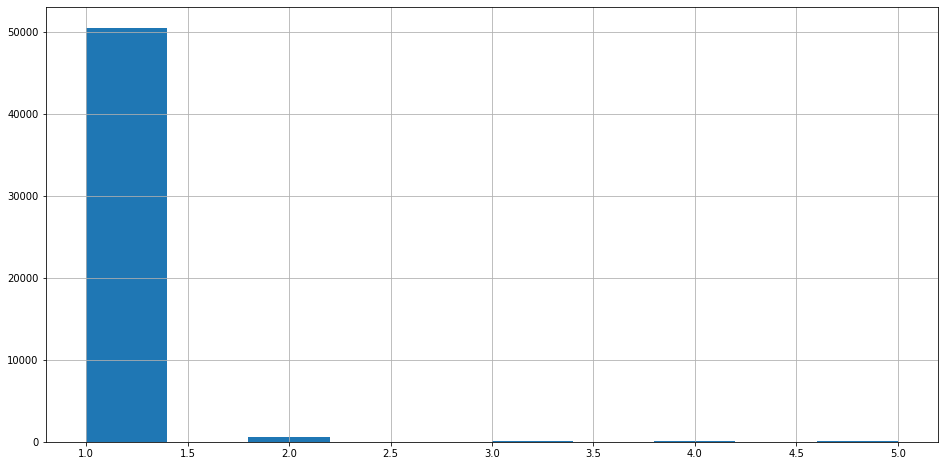

In [ ]:
train_df.drop(train_df[train_df['RatecodeID'] > 6].index, axis=0, inplace = True) # RatecodeID values lies in 1-5
train_df[train_df.RatecodeID < 7].RatecodeID.hist(bins=10, figsize = (16,8))

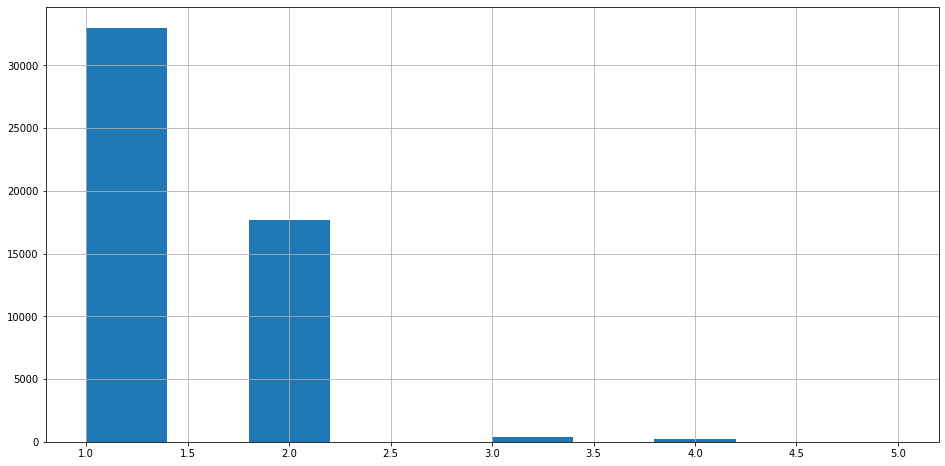

In [ ]:
train_df[train_df.payment_type < 6].payment_type.hist(bins=10, figsize = (16,8)) # analysing payment_type

In [ ]:
train_df[train_df.fare_amount > 100 ].shape # Fare amounts greater than 100 are too low so can be removed 

(44, 11)

Text(0, 0.5, 'Frequency')

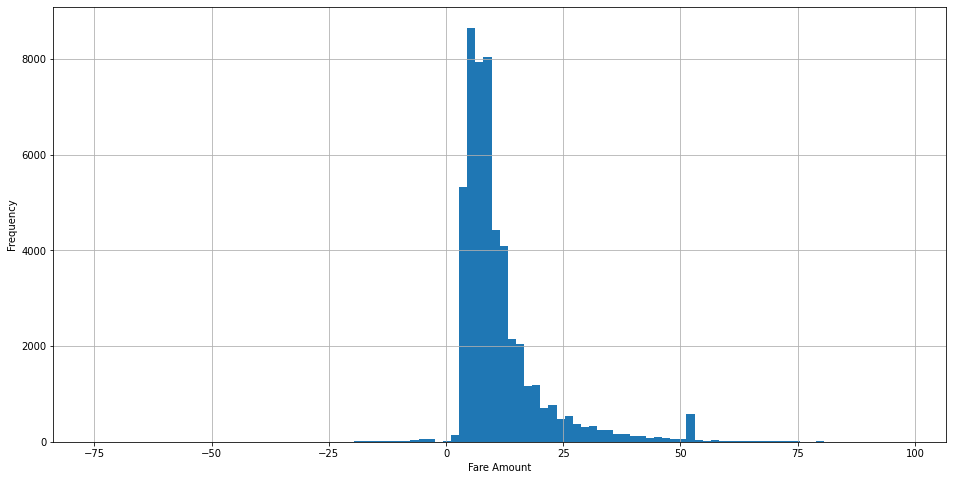

In [ ]:
train_df[train_df.fare_amount <100 ].fare_amount.hist(bins=100, figsize = (16,8)) # visualising fare amount
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")

In [ ]:
train_df.drop(train_df[train_df['fare_amount'] <= 0].index, axis=0, inplace = True) # fare cannot be 0 or negative
train_df.drop(train_df[train_df['fare_amount'] > 100].index, axis=0, inplace = True)

In [ ]:
train_df[train_df.fare_amount < 2.5].shape # This clearly shows minimum rate should be atleast 2.5

(2, 11)

In [ ]:
train_df.drop(train_df[train_df['fare_amount'] < 2.5].index, axis=0, inplace = True)

In [ ]:
def add_datetime_info_pu(dataset): # extracting days,months,year,weekday from the given format
    #Convert to datetime format
    dataset['tpep_pickup_datetime'] = pd.to_datetime(dataset['tpep_pickup_datetime'],format="%Y-%m-%d %H:%M:%S")
    dataset['hour'] = dataset.tpep_pickup_datetime.dt.hour
    dataset['day'] = dataset.tpep_pickup_datetime.dt.day
    dataset['month'] = dataset.tpep_pickup_datetime.dt.month
    dataset['weekday'] = dataset.tpep_pickup_datetime.dt.weekday
    dataset['year'] = dataset.tpep_pickup_datetime.dt.year
    return dataset

def add_datetime_info_do(dataset):
    #Convert to datetime format
    dataset['tpep_dropoff_datetime'] = pd.to_datetime(dataset['tpep_dropoff_datetime'],format="%Y-%m-%d %H:%M:%S")
    dataset['hour'] = dataset.tpep_dropoff_datetime.dt.hour
    dataset['day'] = dataset.tpep_dropoff_datetime.dt.day
    dataset['month'] = dataset.tpep_dropoff_datetime.dt.month
    dataset['weekday'] = dataset.tpep_dropoff_datetime.dt.weekday
    dataset['year'] = dataset.tpep_dropoff_datetime.dt.year
    return dataset
train_df = add_datetime_info_pu(train_df)
train_df = add_datetime_info_do(train_df)

In [ ]:
train_df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)

In [ ]:
train_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge,hour,day,month,weekday,year
count,50987.000000,50987.000000,50987.000000,50987.000000,50987.000000,50987.000000,50987.000000,50987.000000,50987.000000,50987.000000,50987.000000,50987.000000,50987.000000,50987.000000
mean,1.623669,1.398141,2.894552,1.022143,160.988683,155.864456,1.363701,11.588601,2.175996,13.682958,16.990213,6.000078,2.581246,2019.999784
std,0.484469,1.010320,3.388597,0.224687,68.303478,73.316556,0.506916,9.626588,0.839670,4.855799,8.615036,0.025823,1.919016,0.048715
min,1.000000,1.000000,0.010000,1.000000,1.000000,1.000000,1.000000,2.500000,0.000000,0.000000,1.000000,1.000000,0.000000,2009.000000
25%,1.000000,1.000000,1.040000,1.000000,113.000000,90.000000,1.000000,6.000000,2.500000,10.000000,10.000000,6.000000,1.000000,2020.000000
50%,2.000000,1.000000,1.800000,1.000000,161.000000,158.000000,1.000000,8.500000,2.500000,14.000000,18.000000,6.000000,2.000000,2020.000000
75%,2.000000,1.000000,3.200000,1.000000,234.000000,234.000000,2.000000,13.000000,2.500000,17.000000,24.000000,6.000000,4.000000,2020.000000
max,2.000000,6.000000,40.050000,5.000000,265.000000,265.000000,5.000000,100.000000,2.500000,23.000000,30.000000,7.000000,6.000000,2020.000000


In [ ]:
y = train_df['fare_amount'] # ground-truth values
train_df = train_df.drop(columns=['fare_amount'])
x_train,x_test,y_train,y_test = train_test_split(train_df,y,random_state=123,test_size=0.10)

params = {                                              
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }    # manually hypertuned
    
train_set = lgbm.Dataset(x_train, y_train, silent=False,categorical_feature=['year','month','day','weekday'])  # Using lightgbm model 
valid_set = lgbm.Dataset(x_test, y_test, silent=False,categorical_feature=['year','month','day','weekday'])
model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.56223
[1000]	valid_0's rmse: 1.54057
Early stopping, best iteration is:
[979]	valid_0's rmse: 1.54044


In [ ]:
y_pred = model.predict(x_test)    # Test error
print(mse(y_test, y_pred,squared=False))

1.5405906461434669


In [ ]:
y_predc = model.predict(x_train)  # Training error
print(mse(y_train, y_predc,squared=False))

1.2218166081370903


In [ ]:
test_df = pd.read_csv("/content/test_data_iitm.csv")    # reading test data
test_df = test_df.drop(["store_and_fwd_flag"],axis = 1).fillna(0)
test_df = add_datetime_info_pu(test_df)
test_df = add_datetime_info_do(test_df)
test_df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)

In [ ]:
y_predi = model.predict(test_df).round(2)   #predicting fare_amount using the trained model
test_df["fare_amount"] = y_predi
test_df.to_csv("/content/test_data_iitm.csv",index=False)

In [ ]:
test_df.head()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,congestion_surcharge,hour,day,month,weekday,year,fare_amount
0,2.0,1.0,1.66,1.0,48,90,1.0,2.5,18,30,6,1,2020,7.74
1,2.0,3.0,1.50,1.0,48,246,2.0,2.5,23,27,6,5,2020,7.29
2,1.0,1.0,1.90,1.0,237,234,1.0,2.5,13,9,6,1,2020,8.94
3,2.0,1.0,0.27,1.0,170,170,2.0,2.5,9,20,6,5,2020,3.05
4,2.0,2.0,4.06,1.0,186,238,2.0,2.5,18,23,6,1,2020,15.85
